In [129]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import hdbscan
import socket
import struct

In [154]:
DS1 = "csv/convert/capture1_1.csv"
DSMERGED = "csv/convert/capture_merge_1.csv"
LOG = "csv/conn.log.labeled"

# Datensatzauswahl

Welche Datensätze haben wir in betracht gezogen und warum haben wir uns für diesen entschieden?

# Vorstellung der .log files und deren Struktur 
### Beispielhaft für Datensatz 1

In [131]:
fields=["ts","uid","orig_h","orig_p","resp_h","resp_p","proto","service","duration","orig_bytes","resp_bytes","conn_state","local_orig","local_resp","missed_bytes","history","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes","tunnel_parents","label","detailed-label"]

df_raw_log = pd.read_csv(LOG,skipfooter=1, engine="python", names=fields, sep="\x09|\x20\x20\x20", skiprows=8)
df_raw_log = df_raw_log.replace('-', np.nan)


In [132]:
pd.set_option('display.max_columns', None)
df_raw_log.head()

,ts,uid,orig_h,orig_p,resp_h,resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,tcp,NaN,2.999051,0,0,S0,NaN,NaN,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,NaN,2.998796,0,0,S0,NaN,NaN,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan


### Spaltenübersicht

<div style="tposition>
    
| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | X         |
| uid		        | UUID 			                    | X         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | X         |
| duration		    | Dauer 			                | X         |
| orig_bytes		| Ursprüngliche Bytes 		        | X         |
| resp_bytes		| Antwortbytes 			            | X         |
| conn_state		| Verbindungszustand 		        | X         |
| local_orig		| Lokal (Ursprung) 		            | X         |
| local_resp		| Lokal (Antwort) 		            | X         |
| missed_bytes	    | Verpasste Bytes 		            | X         |
| history		    | Historie 			                | X         |
| orig_pkts		    | Ursprüngliche Pakete 		        | X         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | X         |
| resp_pkts		    | Antwortpakete 			        | X         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | X         |
| tunnel_parents	| Tunnel-Eltern 			        | X         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | X         |
</div>

In [70]:
df_raw_log.columns

Index(['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service',
       'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig',
       'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes',
       'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label',
       'detailed-label'],
      dtype='object')

In [71]:
df_raw_log.isna().sum()

ts                      0
uid                     0
orig_h                  0
orig_p                  0
resp_h                  0
resp_p                  0
proto                   0
service           1005507
duration           796300
orig_bytes         796300
resp_bytes         796300
conn_state              0
local_orig        1008748
local_resp        1008748
missed_bytes            0
history             17421
orig_pkts               0
orig_ip_bytes           0
resp_pkts               0
resp_ip_bytes           0
tunnel_parents          0
label                   0
detailed-label     469275
dtype: int64

| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | X         |
| uid		        | UUID 			                    | X         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | X         |
| duration		    | Dauer 			                | X         |
| orig_bytes		| Ursprüngliche Bytes 		        | X         |
| resp_bytes		| Antwortbytes 			            | X         |
| conn_state		| Verbindungszustand 		        | X         |
| local_orig		| Lokal (Ursprung) 		            | X         |
| local_resp		| Lokal (Antwort) 		            | X         |
| missed_bytes	    | Verpasste Bytes 		            | X         |
| history		    | Historie 			                | X         |
| orig_pkts		    | Ursprüngliche Pakete 		        | X         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | X         |
| resp_pkts		    | Antwortpakete 			        | X         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | X         |
| tunnel_parents	| Tunnel-Eltern 			        | X         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | X         |


## Encoding der Spalten

In [72]:
protos = list(df_raw_log.proto.unique().flatten())
conn_states = list(df_raw_log.conn_state.unique().flatten())
histories = list(df_raw_log.history.unique().flatten())
def convert_ipv4(addr):
    """Konvertieren einer IPv4 Adresse zu einem INT"""
    return struct.unpack("!I", socket.inet_aton(addr))[0]

def con_proto(proto):
    """Konvertieren der Ports ICMP, TCP und UDP zu einem INT"""
    return protos.index(proto)

def convert_connstate(state):
    return conn_states.index(state)

def convert_histories(history):
    return histories.index(history)
        

### Konvertieren des DataFrames in ein normiertes Format
1. Konvertieren der IPv4 Spalten
2. Konvertieren der Protokoll Spalte
3. Löschen der ts und uid spalten

In [73]:
def norm_df(df):
    """
    Normierung des DataFrames, dh löschen der Spalten, welche nicht gebraucht werden und konvertieren der object Spalten zu INT
    """
    df = df.replace('-', np.nan)
    df['orig_h'] = df['orig_h'].apply(convert_ipv4)
    df['resp_h'] = df['resp_h'].apply(convert_ipv4)
    df['proto'] = df['proto'].apply(con_proto)
    df['conn_state'] = df['conn_state'].apply(convert_connstate)
    df['history'] = df['history'].apply(convert_histories)
    df = df.drop(['uid', 'ts', 'tunnel_parents', 'detailed-label', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp'], axis=1)
    df['label'] = (df['label'] == "Malicious").astype(int)
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [74]:
df_conversion_1 = norm_df(df_raw_log)

In [75]:
df_conversion_1.dtypes

orig_h           int64
orig_p           int64
resp_h           int64
resp_p           int64
proto            int64
conn_state       int64
missed_bytes     int64
history          int64
orig_pkts        int64
orig_ip_bytes    int64
resp_pkts        int64
resp_ip_bytes    int64
label            int64
dtype: object

In [76]:
df_conversion_1.head(20)

,orig_h,orig_p,resp_h,resp_p,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,3232261223,51524,1098901923,23,0,0,0,0,3,180,0,0,1
1,3232261223,56305,1066799275,23,0,0,0,0,1,60,0,0,1
2,3232261223,41101,1864898353,23,0,0,0,0,1,60,0,0,1
3,3232261223,60905,2209273747,23,0,0,0,0,3,180,0,0,1
4,3232261223,44301,1529491263,23,0,0,0,0,1,60,0,0,1
5,3232261223,50244,2027056328,23,0,0,0,0,1,60,0,0,1
6,3232261223,34243,2466726347,49560,0,0,0,0,3,180,0,0,0
7,3232261223,34840,2443453190,21288,0,0,0,0,1,60,0,0,0
8,3232261223,58525,2974521213,23,0,0,0,0,1,60,0,0,1
9,3232261223,43849,1586579063,8080,0,0,0,0,1,60,0,0,1


In [77]:
df_conversion_1.label.value_counts()

label
1    539473
0    469275
Name: count, dtype: int64

In [78]:
def viz(df):
    for c, label in enumerate(df.columns):
        counts, edges, bars = plt.hist(df[df["label"] == 1][label], color='blue', label='Malicious', alpha=0.7, density=True, stacked=True)
        counts2, edges2, bars2 = plt.hist(df[df["label"] ==  0][label], color='red', label='Benign', alpha=0.7, density=True, stacked=True)
        plt.title(label)
        plt.ylabel("probability density")
        plt.xlabel(label)
        plt.legend()
        plt.show()

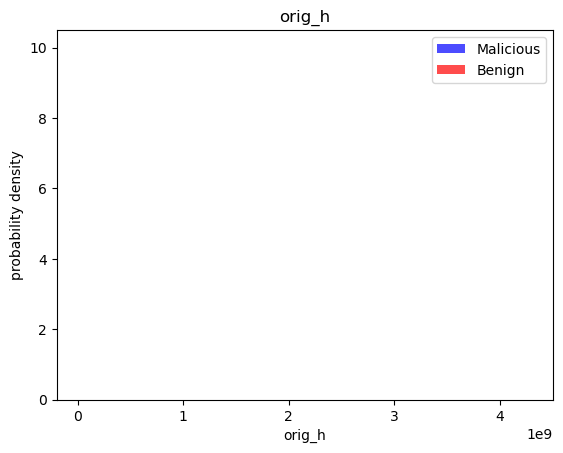

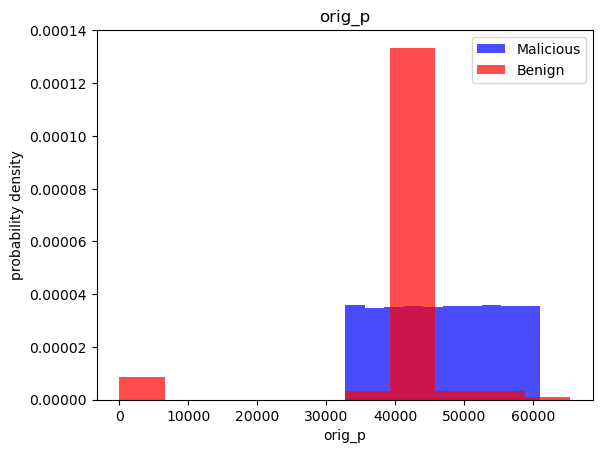

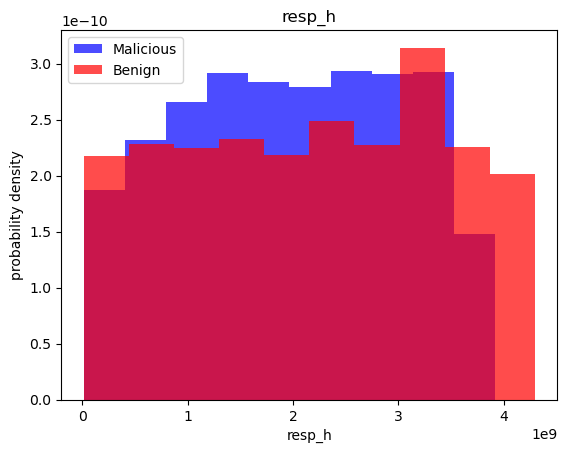

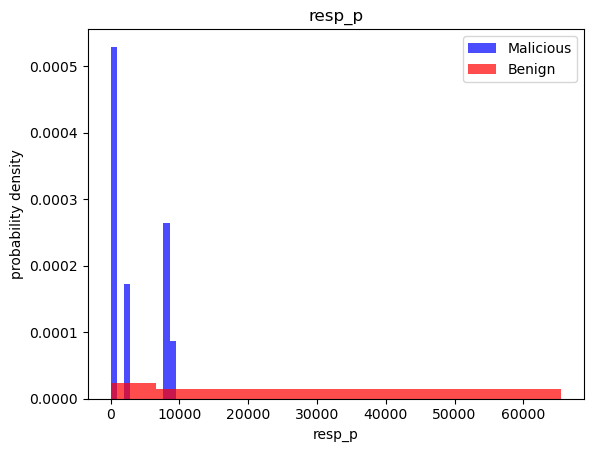

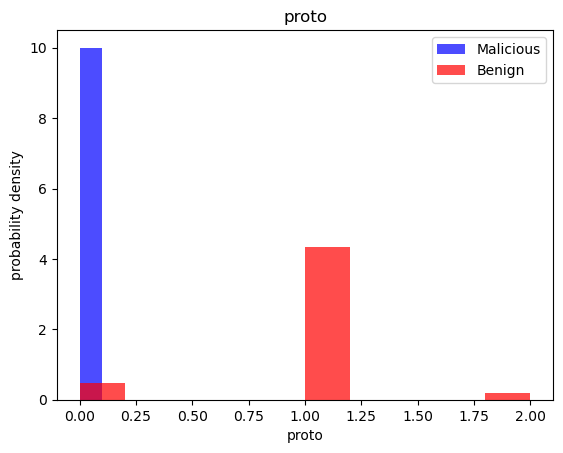

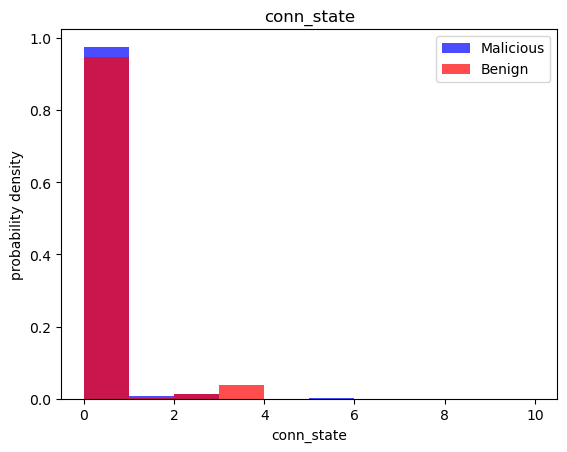

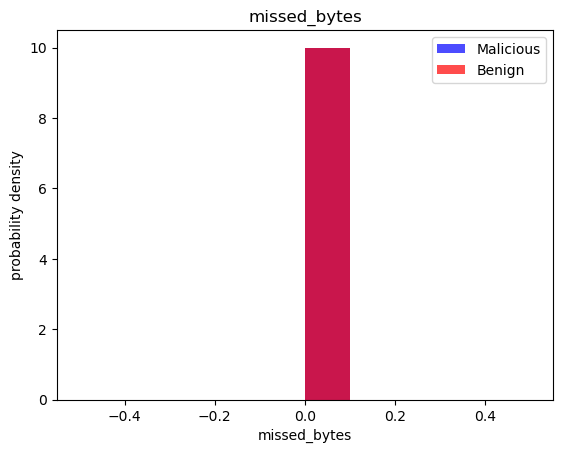

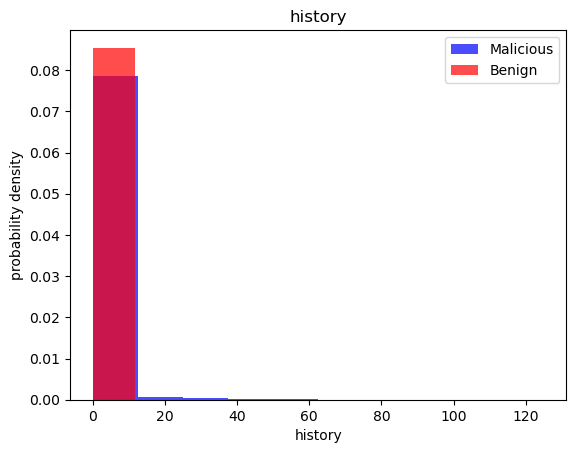

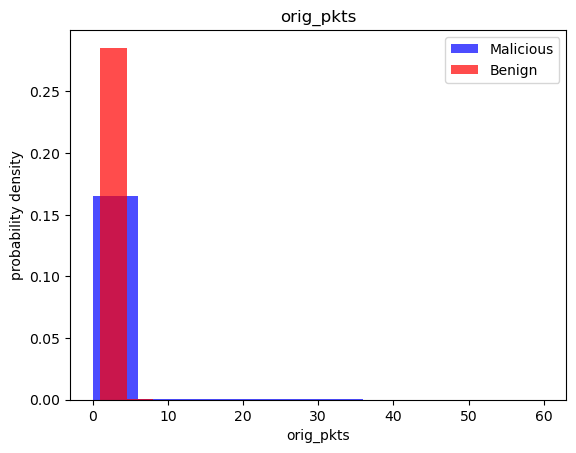

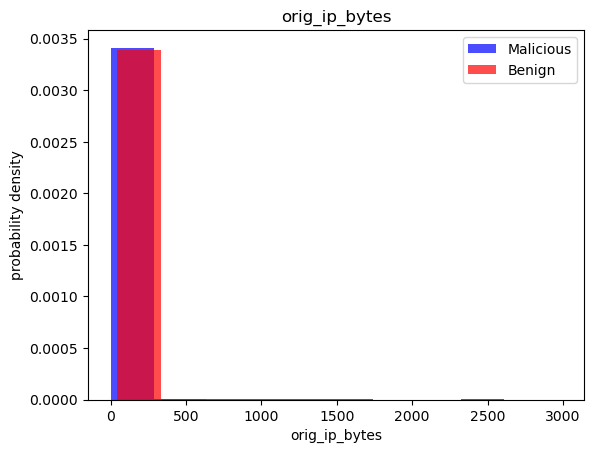

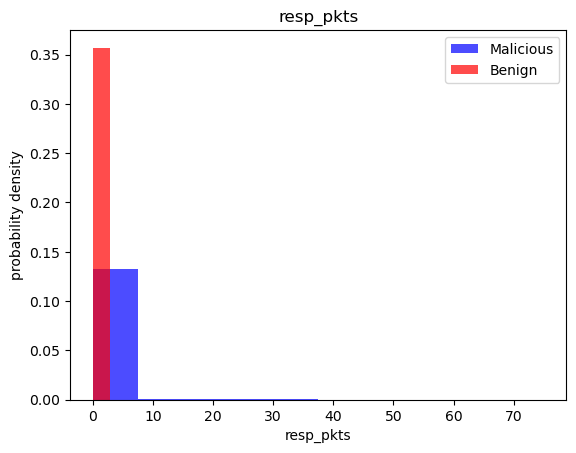

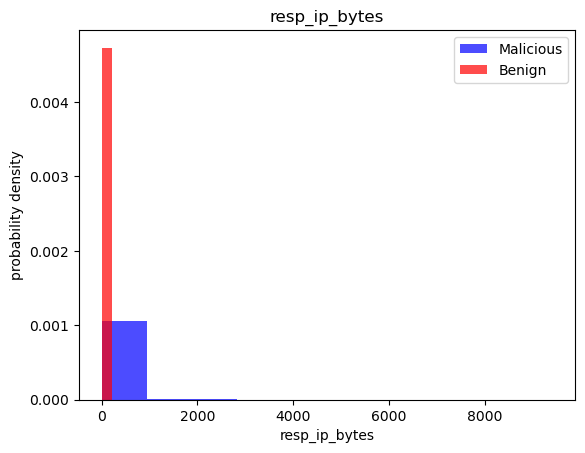

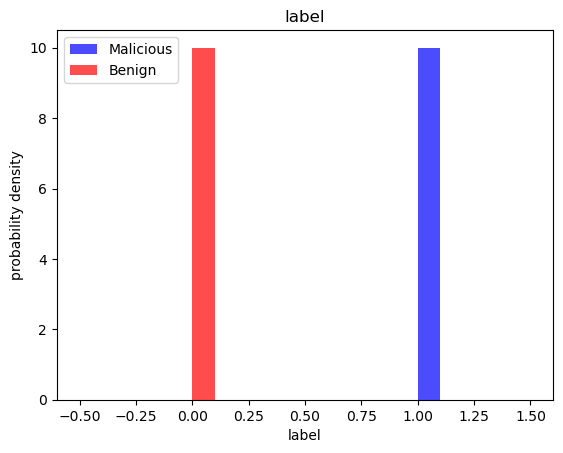

In [79]:
viz(df_conversion_1)

## Scatter plot der Daten

In [85]:
def make_bytes_plot(df) -> plt.figure:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='label', ax=ax1)
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='proto', ax=ax3)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='label', ax=ax2)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='proto', ax=ax4)
    plt.show()
    return fig

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


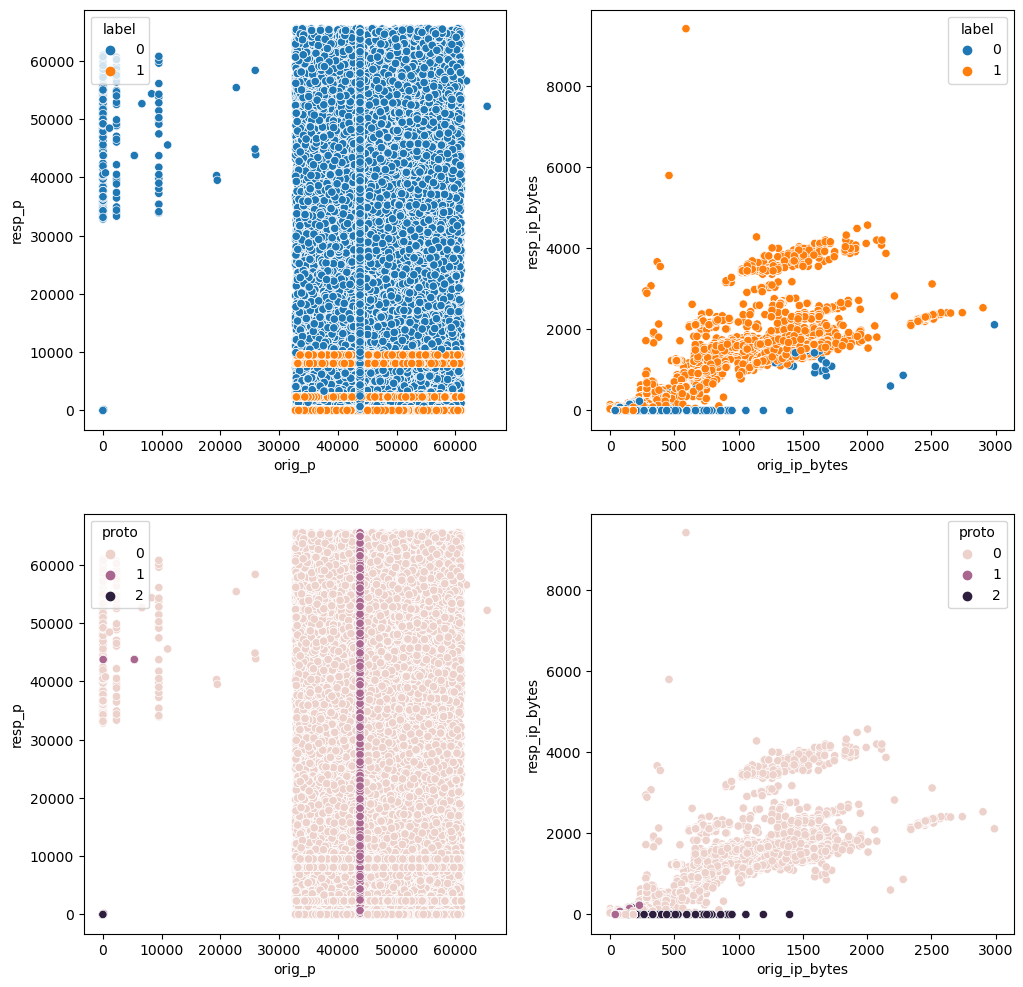

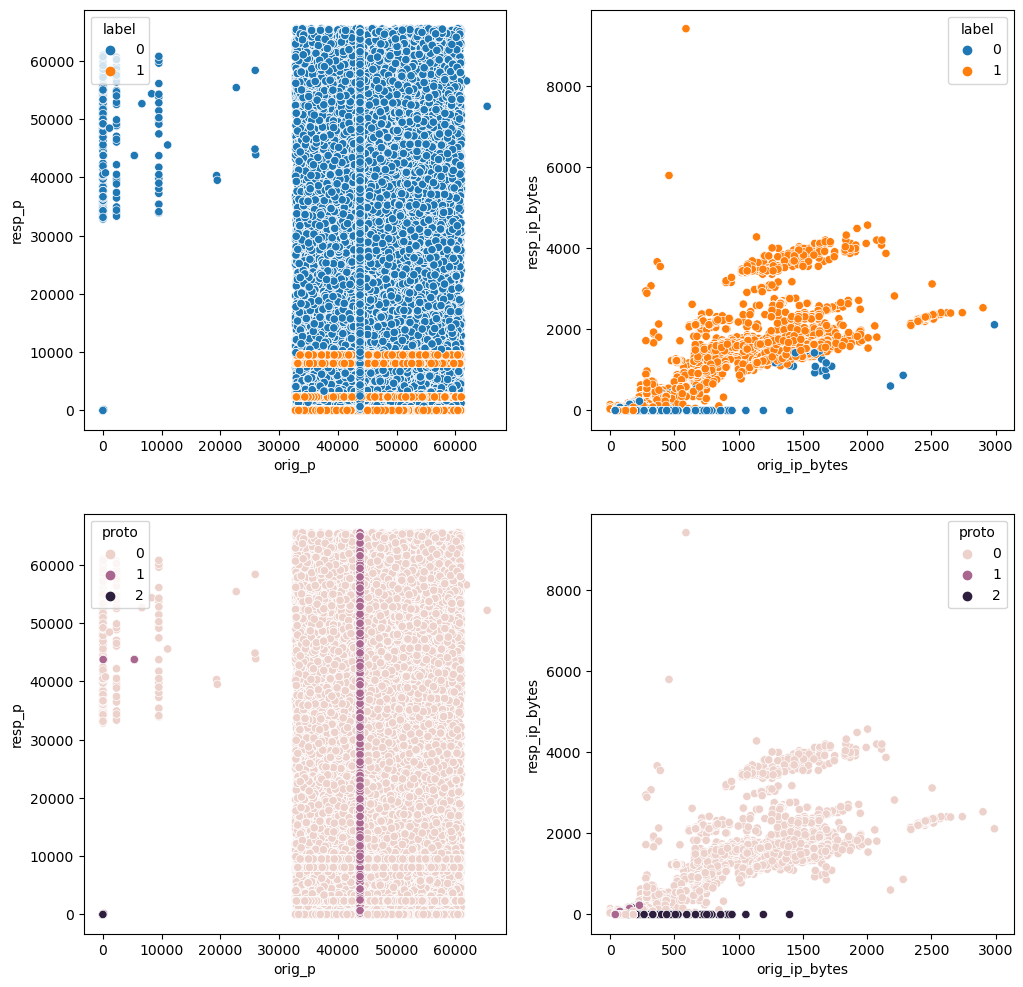

In [86]:
make_bytes_plot(df_conversion_1)

# Konvertierung eines .log files in eine CSV

In [168]:
df_ds1 = pd.read_csv(DS1)
df_ds1 = df_ds1.drop(['Unnamed: 0'], axis=1)
df_dsmerged = pd.read_csv(DSMERGED)
df_dsmerged = df_dsmerged.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [170]:
df_ds1

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,59686,1159721954,8080,1,1
1,3232261223,43763,3663581508,47061,2,0
2,3232261223,51353,2712346730,2323,1,1
3,3232261223,43763,2028023405,39377,2,0
4,3232261223,45543,987512794,23,1,1
...,...,...,...,...,...,...
1008740,3232261223,44552,873217422,2323,1,1
1008741,3232261223,52111,3145280628,23,1,1
1008742,3232261223,56553,593749694,2323,1,1
1008743,3232261223,48087,716058614,8080,1,1


In [169]:
df_dsmerged

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,43763,3663581508,47061,2,0
1,3232261223,43763,2028023405,39377,2,0
2,3232261223,43763,2713856255,20457,2,0
3,3232261223,43763,1066870262,16504,2,0
4,3232261223,43763,3798348164,37327,2,0
...,...,...,...,...,...,...
2123247,3232235972,3372,908547944,992,1,1
2123248,3232235972,30751,3512843912,80,1,1
2123249,3232235972,16764,908547944,992,1,1
2123250,3232235972,4020,3512843912,80,1,1


---

# Klassifizierung der Daten mit DBSCAN und HDBSCAN

## Beispielhaft für Datensatz 1

In [91]:
def dbscanner(df, title):
    dbscan = DBSCAN(eps=8, min_samples=4).fit(df)
    labels=dbscan.labels_
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue=labels, ax=ax1)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue=labels, ax=ax2)
    plt.title(title)
    plt.show()

In [98]:
def hdbscanner(df, title):
    hdbscan_obj = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5, min_samples=None, p=None).fit(df)
    labels = hdbscan_obj.labels_
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue=labels, ax=ax1)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue=labels, ax=ax2)
    plt.title(title)
    plt.show()

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


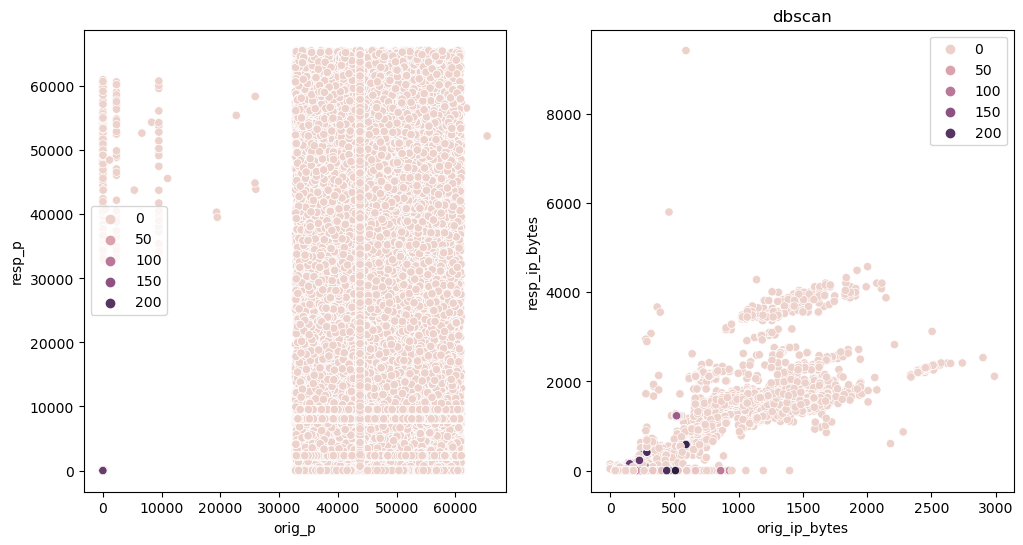

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


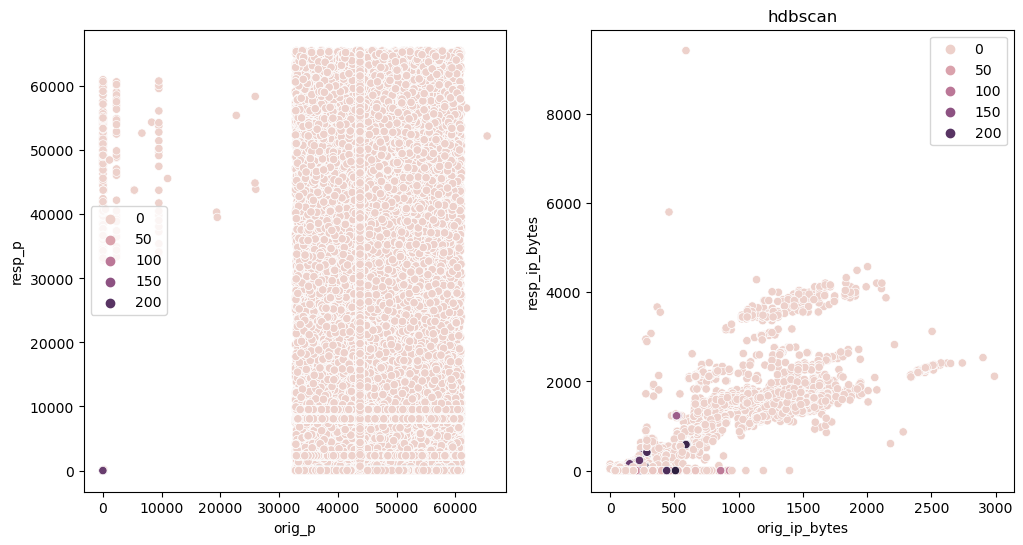

In [99]:
dbscanner(df_conversion_1, "dbscan")
dbscanner(df_conversion_1, "hdbscan")

---

# Mergen der dateien 1, 7, 35

In [135]:
def merge(datasets):
  df_return = pd.DataFrame()
  for d in datasets:
    df = pd.read_csv(f"work/csv/convert/capture{d}_1.csv")
    print(f"====\nDF{d}")
    print(f"shape before: {df.shape}")
    print(f"labels before:\n\t1:: {len(df[df['label'] == 1])}\n\t0:: {len(df[df['label'] == 0])}")
    l_dfs = [df[df['label'] == 0], df[df['label'] == 1]]
    for label in [0,1]:
      if len(l_dfs[label]) > 500_000:
        percent = 500_000 / len(l_dfs[label])
        print(f"cut {1-percent} off label == {label}")
        l_dfs[label] = np.array_split(l_dfs[label].sample(frac=1), 1/percent)[0]
    df = pd.concat(l_dfs, ignore_index=1)
    df_return = pd.DataFrame(pd.concat([df_return,df],ignore_index = True))
  print("=== now changing the df_return ===")
  ones = len(df_return[df_return['label'] == 1])
  zeros = len(df_return[df_return['label'] == 0])
  thebigger = 1 if ones > zeros else 0
  perc = zeros / ones
  print("shape before: ")
  print(df_return["label"].value_counts())
  print(f"ratio: {perc}")
  perc =  1 - perc if perc > 1 else perc
  print(f"cut_perc {perc}")
  l_dfs = [df_return[df_return['label'] == 0], df_return[df_return['label'] == 1]]
  rows_to_cut = int(len(l_dfs[thebigger]) * perc)
  l_dfs[thebigger] = l_dfs[thebigger].iloc[:rows_to_cut]
  df_return = pd.concat(l_dfs)
  print("===\nshape after: ")
  print(df_return["label"].value_counts())
  print(f"shape: {df_return.shape}")
  return df_return

In [136]:
ids = [1,7,35]
df = merge(ids)

FileNotFoundError: [Errno 2] No such file or directory: 'work/csv/convert/capture1_1.csv'

---

# Training der Datensätze

## Split in Training, Validierung und Trainingsdatensatz, Oversampling

In [184]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler

In [185]:
def split(df):
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train, valid, test

In [186]:
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [104]:
train, valid, test = split(df_conversion_1)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

## Datensatz 1

### kNN

In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [107]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [112]:
y_pred = knn_model.predict(X_test)

In [119]:
print(len(y_pred))
print(len(X_test[2]))

201750
12


<function matplotlib.pyplot.show(close=None, block=None)>

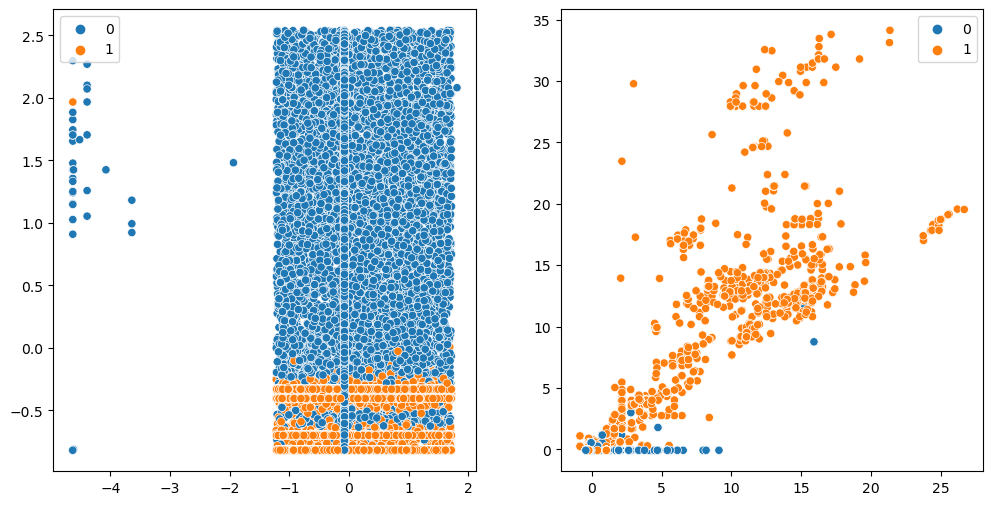

In [126]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.scatterplot(x=pd.DataFrame(X_test)[1].values, y=pd.DataFrame(X_test)[3].values, hue=y_pred, ax=ax1)
sns.scatterplot(x=pd.DataFrame(X_test)[9].values, y=pd.DataFrame(X_test)[11].values, hue=y_pred, ax=ax2)
plt.show

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     93263
           1       0.99      1.00      0.99    108487

    accuracy                           0.99    201750
   macro avg       0.99      0.99      0.99    201750
weighted avg       0.99      0.99      0.99    201750



### bTrees

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# https://towardsdatascience.com/random-forest-classification-678e551462f5?gi=ac29a94cba92

#m_f = 3,  max_depth = 4, max_features = 5, random_state = 18

# hyperparameter optimierung
clf = RandomForestClassifier(n_estimators = 1000, bootstrap = True)

# n_estimators — the number of decision trees you will be running in the model
# max_depth — this sets the maximum possible depth of each tree
# max_features — the maximum number of features the model will consider when determining a split
# bootstrapping — the default value for this is True, meaning the model follows bootstrapping principles (defined earlier).
# max_samples — This parameter assumes bootstrapping is set to True, if not, this parameter doesn’t apply. In the case of True, this value sets the largest size of each sample for each tree.
# Other important parameters are criterion, min_samples_split, min_samples_leaf, class_weights, n_jobs, and others that can be read in the sklearn’s RandomForestClassifier documentation here.



In [ ]:
clf.fit(X_train, y_train)

In [ ]:
# Create our predictions
prediction = clf.predict(X_test)
# Create confusion matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
confusion_matrix(y_test, prediction)

In [ ]:
print(classification_report(y_test, prediction))

In [ ]:
#### Random Forest Plot

In [ ]:
from sklearn.tree import export_graphviz

# Safe data for visulation
tmp = SOURCEDF.copy(deep=True)
_SOURCEDF = tmp.drop(['label'], axis=1)
# Export as dot file
dot_data = export_graphviz(estimator,
                feature_names = _SOURCEDF.columns,
                class_names = _SOURCEDF.columns,
                rounded = True, proportion = False,
                precision = 2, filled = True)

In [ ]:
from IPython.core.display import Image
import pydotplus

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### aNN

## Datensatz merged

### kNN

In [195]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

n_neighbors = 3
X = X_train
y = y_train

In [128]:
#### Hyperparameter Optimierung n_neighbors kNN

In [ ]:
k_values = [i for i in range (1,15)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Crossvaldation 
    '''
    The cross_val_score() function automatically splits the available data into k contiguous subsets (folds), where k is the desired number of folds. 
    It then trains and tests the model k times, using a different fold as the test dataset each time and the remaining folds for training.
    '''
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))
    print(f"finished {k}")

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
# TODO Knn mit 2 + Visualisierung
n_neighbors = 2
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(X_train, y_train)

### bTrees

### Random Forest

### aNN

### DTrees

In [176]:
# Imports
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [187]:
train, valid, test = split(df_ds1)
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

In [188]:
X_train

array([[ 0.09279745, -0.61443018, -0.46753735, -0.82098792, -0.74261529],
       [ 0.09279745,  0.22335303, -0.93744183, -0.82098792, -0.74261529],
       [ 0.09279745, -0.06991768,  0.65787687,  0.9584615 ,  1.17526041],
       ...,
       [ 0.09279745, -0.06991768, -1.56380457,  2.24640452,  1.17526041],
       [ 0.09279745, -0.06991768,  0.20118089,  2.3347101 ,  1.17526041],
       [ 0.09279745, -0.06991768, -1.48024742,  1.71161407,  1.17526041]])

In [189]:
# Create Decision Tree classifer object
# Note: with ccp_alpha you can prune the tree if it is overfitting the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dtree = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtree = dtree.fit(X_train,y_train)

dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [190]:
#Predict the response for test dataset
y_pred = dtree.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [192]:
# show difference between tree that doesn't have stopping criteria and the one that does
dtree.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [193]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.46578173869511125

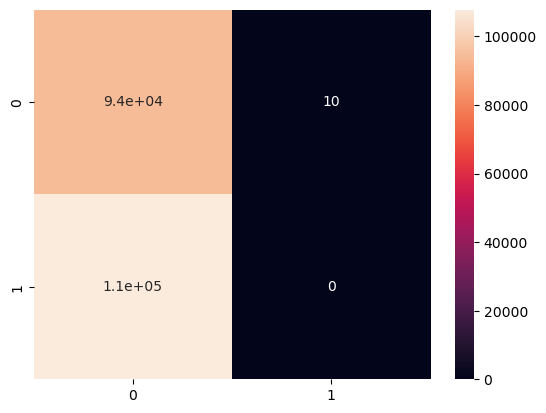

In [194]:
# Confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
sns.heatmap(cm,annot=True)
plt.savefig('img/dtree_confusion.png')